<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/7_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC%EB%A5%BC_%EC%9C%84%ED%95%9C_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 7.1. 순환 구조

이전 값을 사용. 피보나치 수열과 유사

이 부분은 책 보기


### 7.2. 순환을 언어로 확장하기

LSTM(long short-term memory) 구조 사용.

LSTM 구조는 **셀상태** 를 추가해 기본 RNN을 향상시킨다. 셀 상태는 스텝 사이뿐만 아니라 시퀀스 전체에 걸쳐 문맥을 유지하도록 돕는다.

이 구조도 뉴런을 사용하기 때문에 이전과 동일하게 학습하면 중요한 문맥이 학습되는 것을 확인할 수 있다.

LSTM에서는 양방향이 가능하단 점이 중요하다. 즉 **타임스텝이 앞뒤로 반복되면서 문맥을 양방향으로 학습 가능하다.** 셀 상태 또한 양방향이다.

각 타임스텝의 결과는 **정방향** 계산과 **역방향** 계산의 합이다.

문장이 반대방향인 경우는 역방향으로 문장을 학습해야하기 때문에, 양방향 LSTM을 이용하면 문장의 감성을 매우 잘 이해가능

물론 LSTM, 특히 양방향 LSTM은 많은 연산을 수행하므로 훈련 속도가 느리다.

### 7.3. RNN으로 텍스트 분류기 만들기

LSTM과 같은 RNN 층을 사용할 때는 단어를 모을 필요 없이 임베딩 층의 출력을 바로 순환 층에 주입할 수 있다.

이것은 필수는 아니지만 시작점으로는 괜찮다.

6장에서 임베딩 차원을 어휘 사전의 네제곱근으로 맞춘다고 언급했지만 RNN을 사용할 떄는 순환 층의 크기를 작게 만들기 때문에 이 규칙이 잘 지켜지지 않는다.



In [3]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [8]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [13]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-13-b6935b6167ad>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [10]:
vocab_size = 20000
embedding_dim = 64
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [14]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

In [16]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

양뱡향 LSTM 순환층

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

손실함수와 모델은 다음과 같이 설정

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam,
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1349169 (5.15 MB)
Trainable params: 1349169 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


어휘사전의 크기가 20,000이고 임베딩 차원은 64이다.

따라서 임베딩 층의 파라미터 개수는 1,280,000(20,000*64) 이고

양방향층은 뉴런 128개(정방향 64, 역방향 64)개를 갖는다.

In [13]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 29s 32ms/step - loss: 0.6874 - accuracy: 0.5596 - val_loss: 0.6828 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6836 - accuracy: 0.5596 - val_loss: 0.6802 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6811 - accuracy: 0.5596 - val_loss: 0.6772 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 10s 13ms/step - loss: 0.6775 - accuracy: 0.5596 - val_loss: 0.6729 - val_accuracy: 0.5700
Epoch 5/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6716 - accuracy: 0.5597 - val_loss: 0.6662 - val_accuracy: 0.5705
Epoch 6/30
719/719 [==============================] - 8s 11ms/step - loss: 0.6619 - accuracy: 0.5692 - val_loss: 0.6549 - val_accuracy: 0.5932
Epoch 7/30
719/719 [==============================] - 9s 13ms/step - loss: 0.6471 - accuracy: 0.6167 - val_loss: 0.6394 - val_accuracy: 0

시간이 매우 오래 걸린다..?는 **코랩 gpu로 돌리면 매우 빨라진다.**

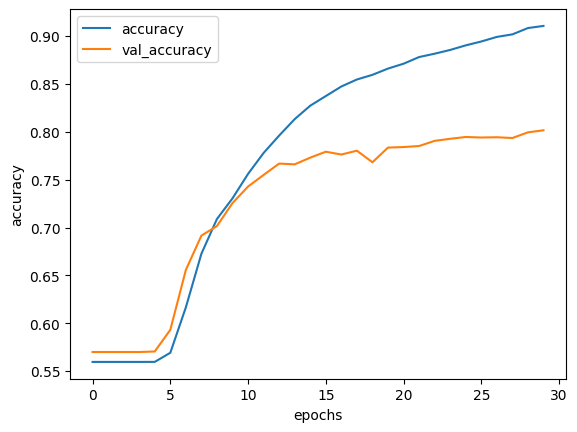

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

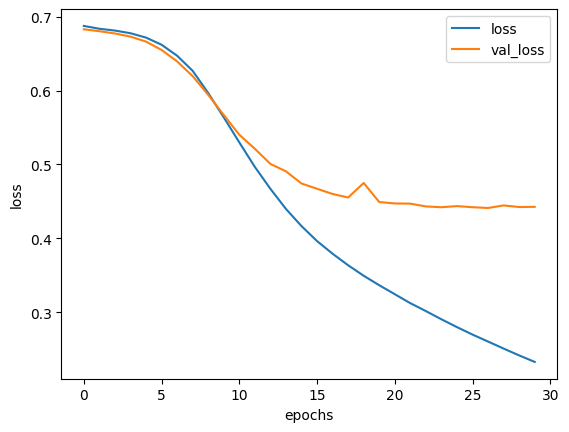

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

정확도가 90%까지 빠르게 올라간다. 하지만 검증 데이터에 대한 정확도는 80% 근처에서 평평해진다.

손실 그래프를 살펴보면 15번째 에폭을 기점으로 검증세트와 훈련세트 손실의 간격이 급격히 벌어지는 것을 볼 수 있다.

또한 2,000개가 아닌 20,000 개 단어를 사용했음에도 불구하고 6장에서 본 손실그래프보다 훨씬 낮은 값에서 평평해짐



하지만 여기서는 하나의 LSTM 층만 사용했다. 다음 절에서 **스태킹(stacking, 적층) LSTM**을 사용하는 방법과 분류기의 정확도에 미치는 영향에 대해 보겠다.

#### 7.3.1. 스태킹 LSTM

LSTM은 여러 층을 쌓을 수 있으며 최신 자연어 처리 모델에서 이 방식을 많이 사용한다.

간단하게 그냥 층만 더 추가하면 된다.

하지만 다음처럼 마지막 층을 제외한 모든 층은 **return_sequences** 매개변수를 True 로 설정해야 한다.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

마지막 LSTM 층도 retrun_sequences=True로 지정할 수 있지만

이렇게 하면 분류를 위한 밀집층에 하나의 값이 아니라 시퀀스를 전달하게 된다.

나중에 언급하겠지만 모델 출력을 분석할 때 편리할 수 있다.

모델 구조는 다음과 같다.

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1447985 (5.52 MB)
Trainable params: 1447

층을 추가해서 학습해야할 파라미터가 약 100,000개 정도 추가되어 8% 정도 늘어났다.

신경망의 속도는 느려지겠지만, 비용이 상대적으로 낮아진다는 합리적인 이점도 있다.

30번의 에폭으로 훈련 시켜보겠다.

In [19]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam,
              metrics=['accuracy'])

num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 30s 33ms/step - loss: 0.6881 - accuracy: 0.5596 - val_loss: 0.6831 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 19s 26ms/step - loss: 0.6844 - accuracy: 0.5596 - val_loss: 0.6807 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6817 - accuracy: 0.5596 - val_loss: 0.6763 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 17s 23ms/step - loss: 0.6723 - accuracy: 0.5610 - val_loss: 0.6593 - val_accuracy: 0.5826
Epoch 5/30
719/719 [==============================] - 16s 22ms/step - loss: 0.6277 - accuracy: 0.6615 - val_loss: 0.5919 - val_accuracy: 0.6988
Epoch 6/30
719/719 [==============================] - 15s 21ms/step - loss: 0.5100 - accuracy: 0.7634 - val_loss: 0.5127 - val_accuracy: 0.7468
Epoch 7/30
719/719 [==============================] - 15s 21ms/step - loss: 0.4190 - accuracy: 0.8149 - val_loss: 0.4846 - val_accuracy:

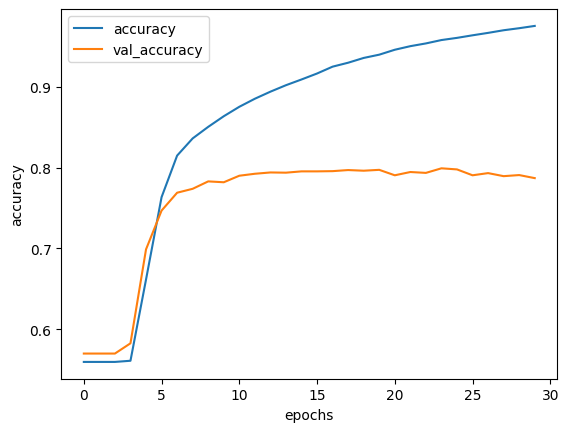

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

훈련 세트와 검증 세트 정확도는 좋아보인다.

그러나 손실 그래프를 보면 검증 손실이 빠르게 높아지는 것을 볼 수 있다.

이 현상은 과대적합을 나타내는 명백한 신호이다.

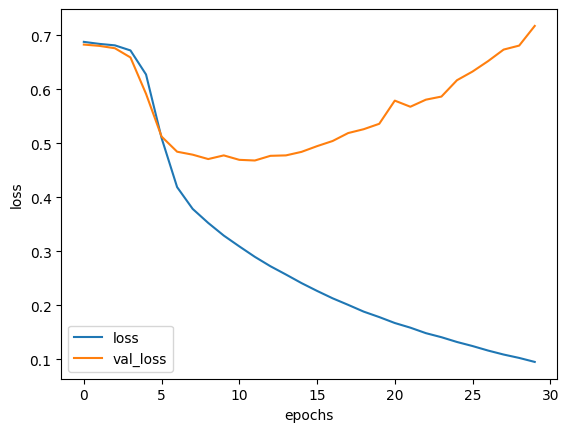

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

훈련 정확도가 100%를 향해 상승하고 손실은 점진적으로 하락하는 양상을 보인다.

반면 검증 정확도는 비교적 일정하고 손실은 급격히 올라간다.

이런 과대적합은 모델이 훈련 세트에 과도하게 맞춰진 결과이다.

***
**손실과 정확도**

정확도(Accuracy)는 전체 데이터에 대한 예측 오류의 수로 볼 수 있다. 쉽게 말해, 전체 데이터 중에서 몇 개를 맞췄는가이다. 100개 중 97개를 맞췄다면 accuracy는 97%이다.

손실(Loss)은 실제 정답과 모델이 예측 한 값 사이의 차이(거리 또는 오차)이다. 즉, 손실이 클수록 데이터에 대한 오류도 커진다. 쉽게 말해, 틀리게 예측한 경우 얼마나 오류를 범했는가로 볼 수 있다. 따라서 2개의 모델이 100개 중 97개를 똑같이 맞춰도 둘의 오차는 다를 수 있다.

***

##### **스태킹 LSTM 최적화하기**

**학습률 낮추기**
0.000008로 낮춰보겠다.(20%)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam,
              metrics=['accuracy'])

num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 34s 37ms/step - loss: 0.6888 - accuracy: 0.5547 - val_loss: 0.6837 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6836 - accuracy: 0.5596 - val_loss: 0.6796 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 16s 22ms/step - loss: 0.6805 - accuracy: 0.5596 - val_loss: 0.6758 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 15s 20ms/step - loss: 0.6732 - accuracy: 0.5633 - val_loss: 0.6634 - val_accuracy: 0.6050
Epoch 5/30
719/719 [==============================] - 16s 22ms/step - loss: 0.6487 - accuracy: 0.6446 - val_loss: 0.6307 - val_accuracy: 0.6700
Epoch 6/30
719/719 [==============================] - 17s 23ms/step - loss: 0.6030 - accuracy: 0.6933 - val_loss: 0.5847 - val_accuracy: 0.6959
Epoch 7/30
719/719 [==============================] - 17s 23ms/step - loss: 0.5203 - accuracy: 0.7516 - val_loss: 0.5052 - val_accuracy:

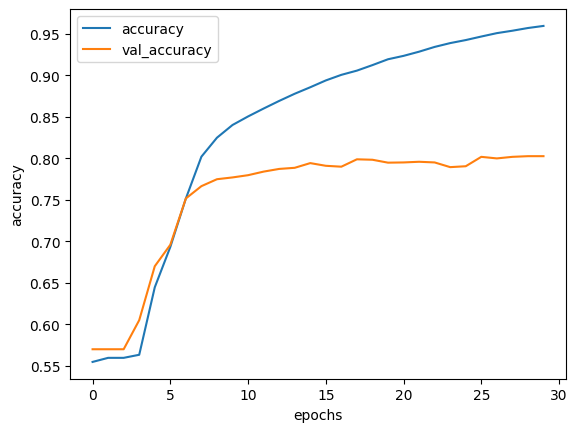

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

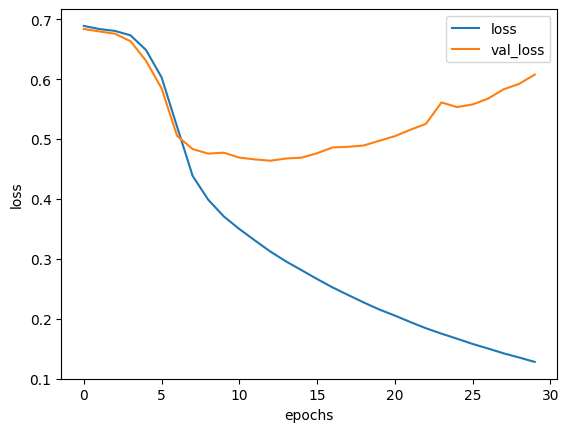

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

변화가 많이 없는 거 같지만 곡선히(특히 검증 세트의 곡선이) 조금 부드러워졌다.

손실 곡선에서 초기모습은 학습률 감소로 인한 손실에 영향이 작은 것 같지만 조금 더 자세히 보자.


곡선의 모양이 거의 비슷하지만 손실의 증가율이 확실히 낮다.

30번의 에폭 후에 손실이 약 0.6인 반면 이보다 더 높은 학습률에서는 0.8에 가까웠다.

학습률 하이퍼파라미터는 확실히 조정해볼 만한 가치가 있다.

##### **드롭아웃 사용하기**

순환층에서 드롭아웃은 밀집 층과 동일하게 작용한다.

인접한 뉴런이 비슷해져 학습에 영향을 미치는 것을 방지하기 위해 뉴런을 랜덤하게 제외시킨다.

드롭아웃은 LSTM 층에 매개변수로 적용할 수 있다.

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

드롭아웃을 적용하면 훈련속도가 느려진다.

In [29]:
adam = tf.keras.optimizers.Adam(learning_rate=0.000008,
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [30]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 36s 36ms/step - loss: 0.6890 - accuracy: 0.5505 - val_loss: 0.6833 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 16s 23ms/step - loss: 0.6835 - accuracy: 0.5596 - val_loss: 0.6796 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 16s 23ms/step - loss: 0.6804 - accuracy: 0.5596 - val_loss: 0.6757 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 19s 26ms/step - loss: 0.6747 - accuracy: 0.5600 - val_loss: 0.6672 - val_accuracy: 0.5737
Epoch 5/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6576 - accuracy: 0.6097 - val_loss: 0.6371 - val_accuracy: 0.6611
Epoch 6/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6110 - accuracy: 0.6806 - val_loss: 0.5888 - val_accuracy: 0.6905
Epoch 7/30
719/719 [==============================] - 17s 24ms/step - loss: 0.5401 - accuracy: 0.7304 - val_loss: 0.5224 - val_accuracy:

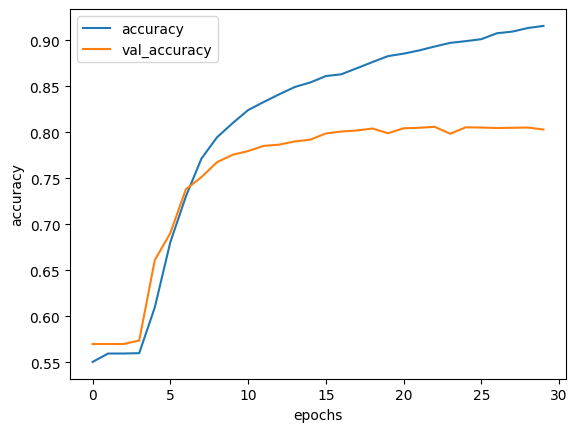

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

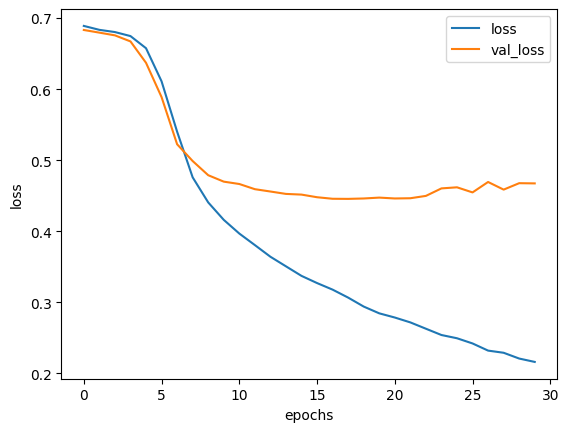

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

여기서 볼 수 있듯이 **드롭아웃은 신경망의 정확도에 큰 영향을 끼치지 않기 떄문에 좋다.**

뉴런을 드롭아웃하면 모델 성능이 나빠진다는 우려가 있지만 그래프에서 볼 수 있듯이 그렇지 않다.

손실곡선을 보면 손실 측면에서는 긍정적인 효과를 볼 수 있다.

곡선이 확실히 벌어지고 있지만 이전보단 가깝다. 검증 세트 손실이 0.5 근방에서 평탄해진다. 이전의 0.8보단 확실히 좋다.

**이 예에서 볼 수 있듯이 드롭아웃은 LSTM 기반의 RNN의 성능을 향상시킬 수 있는 유용한 기법이다.**

### 7.4. RNN에 사전 훈련된 임베딩 사용하기

사전 훈련된 임베딩은 연구원들이 어려운 작업을 통해 단어를 벡터로 바꾸고 결과 벡터를 검증한 결과이다.

사전 훈련된 임베딩의 한 가지 예는 **GloVe** 이다.

먼저 사전훈련된 임베딩을 재사용하려면 Glove 데이터를 다운로드해야 한다.

270억 개 토큰과 120만 개 어휘 사전으로 훈련한 트위터 데이터를 사용하겠다.

다운로드 파일에는 25, 50, 100, 200 차원 벡터가 들어있다.

편의상 25차원 벡터를 따로 만들었다. 콜랩에서 다운로드를 먼저 하겠다.

In [4]:
!wget https://bit.ly/3i9taLA -O glove.zip

--2024-03-06 04:03:08--  https://bit.ly/3i9taLA
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip [following]
--2024-03-06 04:03:08--  https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip
Resolving tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)... 192.0.72.18, 192.0.72.19
Connecting to tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)|192.0.72.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109906941 (105M) [application/zip]
Saving to: ‘glove.zip’

glove.zip           100%[===================>] 104.81M  86.0MB/s    in 1.2s    

2024-03-06 04:03:10 (86.0 MB/s) - ‘glove.zip’ saved [109906941/109906941]



In [5]:
# Glove 임베딩 압축 풀기

import os
import zipfile

local_zip = 'glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('glove')
zip_ref.close()

파일에 있는 각 항목은 단어와 학습된 벡터이다.

이를 사용하는 가장 쉬운 방법은 단어가 키이고 값이 임베딩 벡터인 딕셔너리를 만드는 것이다.

In [6]:
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
# asarray는 array와 같지만 원본이 변경될 경우 asarray의 복사본까지 변경된다.

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  glove_embeddings[word] = coefs
f.close()

In [37]:
glove_embeddings['frog']

array([-1.2158  , -0.74924 ,  0.91941 ,  0.72985 , -0.12917 , -0.19555 ,
        1.2365  , -0.77196 ,  0.85161 ,  0.11922 ,  0.16816 ,  0.33334 ,
       -2.0845  , -0.53471 ,  0.013538,  0.18178 ,  1.2831  ,  0.089331,
        0.57264 ,  0.50694 ,  0.27134 ,  0.66504 ,  0.54097 , -0.58377 ,
        0.67097 ], dtype=float32)

기존처럼 Tokenizer 클래스를 이용해 말뭉치에서 단어 인덱스를 만들 수 있다.

그러나 이제는 임베딩 행렬이라는 새로운 행렬을 만들 수 있다.

이 행렬의 값으로 glove_embeddings에 있는 Glove 임베딩을 사용한다.

임베딩 행렬의 첫 번째 행은 '< OOV >'에 대한 Glove 벡터가 된다. 다음 행은  'new'에 대한 임베딩 벡터가 된다.

다음 코드로 임베딩 행렬을 만들 수 있다.

In [19]:
import numpy as np
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # shape
for word, index in tokenizer.word_index.items():
  if index > vocab_size - 1:
    break
  else:
    embedding_vector = glove_embeddings.get(word)

위 코드는 어휘 사전 크기와 임베딩 차원에 맞는 행렬을 만든다.

그다음 tokenizer의 단어 인덱스에 있는 모든 항목에 대해 glove_embeddings에서 Glove 벡터를 찾아 행렬 추가
***
임베딩 층의 weights 매개변수로 사전 훈련된 임베딩 벡터를 사용하도록 설정한다. 이 층이 훈련되지 않도록 하기 위해 trainable=False로 지정.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

이제 이전처럼 훈련 가능. 하지만 어휘 사전을 고려해야 한다.

과대적합을 피하기 위해 이전 장에서 수행했던 최적화 방법중 하나는 자주 등장하는 단어로 구성된 작은 어휘 사전을 만드는 것이다.

그 전에 사전학습된 Glove에 현재 말뭉치에 있는 모든 단어가 들어있다는 보장을 없다. 그러므로 간단히 비교해본다.

In [22]:
xs = []
ys = []
cumulative_y = []
total_y = 0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  if glove_embeddings.get(word) is not None:
    total_y += 1 # 임베딩에 있는 개수
    ys.append(1) # 임베딩에 있으면1

  else:
    ys.append(0) # 없으면 0
  cumulative_y.append(total_y / index)

In [32]:
#print(ys)

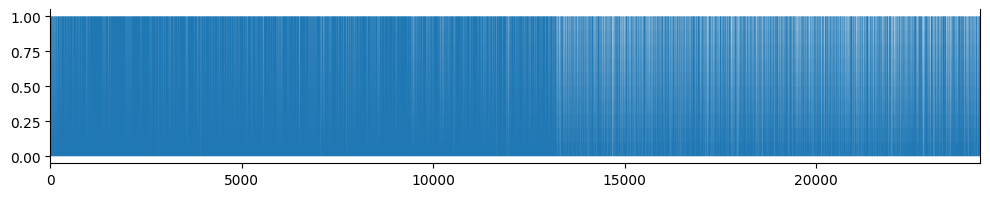

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,2)) # fig는 전체 그림 객체, ax는 축(axes) 객체
ax.spines['top'].set_visible(False)
# 위쪽 테두리(spine)를 숨긴다. 이렇게 하면 그림의 위쪽 테두리가 사라지고, 그림의 윗부분이 더 깔끔해집니다.

plt.margins(x=0, y=None, tight=True)
# x축의 여백을 0으로 설정하고, tight 레이아웃을 사용하여 여백을 최소화합니다. 여백이 없으면 그림의 여백이 최소화되어 데이터 영역이 최대한 확장됩니다.

#plt.axis([1300, 14000, 0, 1])
plt.fill(ys)

그래프에서 볼 수 있듯이 10,000 ~ 15,000 사이에서 밀도가 변한다.

13,000 번 토큰 근처에서 Glove 임베딩에 없는 단어의 빈도가 그렇지 않은 단어보다 많아지는 것을 볼 수 있다

xs와 cumulative_y를 그래프로 그리면 이해하기 더 쉽다.

(0.0, 25000.0, 0.915, 0.985)

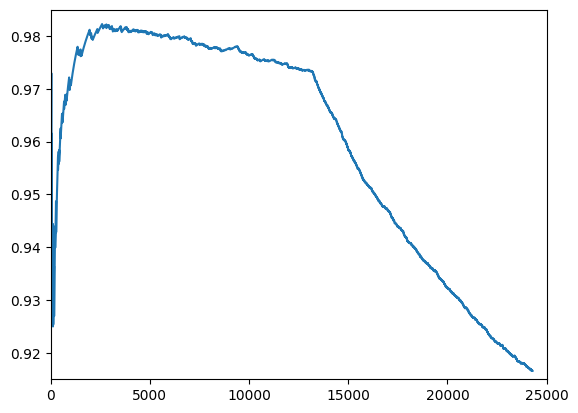

In [33]:
plt.plot(xs, cumulative_y)
plt.axis([0, 25000, .915, .985]) # x축 범위, y축 범위

plt.axis 매개변수를 조정해 그래프를 확대해서 볼 수 있다.

Glove에 없는 단어가 그렇지 않은 단어보다 많아지는 변곡점을 찾을 수 있다. 이 지점이 어휘 사전의 크기를 결정하는 데 좋은 출발점이다.
***
이 방법을 통해 어휘 사전의 크기를 13,200으로 결정했다.(이전에는 과대적합을 피하기 위해 어휘사전 크기 2,000으로 )

embedding_dim은 Glove 데이터가 25차원이기 떄문에 25로 지정

In [34]:
vocab_size = 13200 ### 변경 사항 샵 3개로 표시
embedding_dim = 25 ###
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [36]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [37]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) ### 보캡사이즈 변경
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

In [38]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [40]:

embedding_matrix = np.zeros((vocab_size, embedding_dim)) ### 보캡 사이즈 변경
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001,
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [44]:
epochs = 30
history = model.fit(training_padded, training_labels, epochs=epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 22s 17ms/step - loss: 0.6912 - accuracy: 0.5420 - val_loss: 0.6865 - val_accuracy: 0.5708
Epoch 2/30
719/719 [==============================] - 10s 13ms/step - loss: 0.6839 - accuracy: 0.5730 - val_loss: 0.6799 - val_accuracy: 0.5805
Epoch 3/30
719/719 [==============================] - 11s 16ms/step - loss: 0.6752 - accuracy: 0.6025 - val_loss: 0.6700 - val_accuracy: 0.6228
Epoch 4/30
719/719 [==============================] - 11s 15ms/step - loss: 0.6569 - accuracy: 0.6568 - val_loss: 0.6457 - val_accuracy: 0.6622
Epoch 5/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6289 - accuracy: 0.6635 - val_loss: 0.6265 - val_accuracy: 0.6608
Epoch 6/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6147 - accuracy: 0.6685 - val_loss: 0.6175 - val_accuracy: 0.6676
Epoch 7/30
719/719 [==============================] - 11s 15ms/step - loss: 0.6075 - accuracy: 0.6736 - val_loss: 0.6118 - val_accuracy:

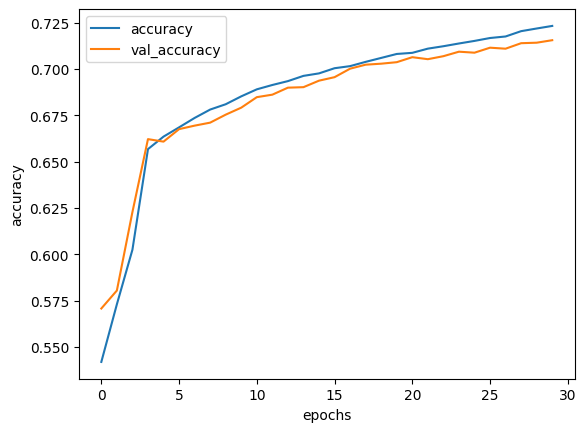

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

그래프를 보면 훌륭한 결과를 얻은 걸 볼 수 있다.

검증 정확도가 훈련 정확도에 아주 가까우므로 더이상 과대적합이 아니다.

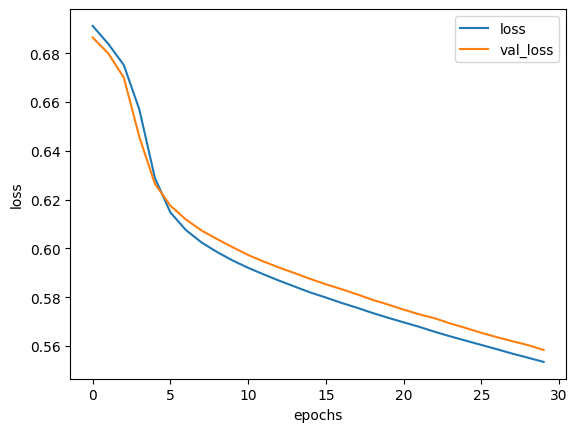

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

손실 곡선을 보면 정확도가 73%로 그렇게 높진 않지만

**검증 손실이 더이상 발산하지 않기 떄문에** 모델이 이 정도에서 정확하다고 확신할 수 있다.

모델을 더 많이 훈련시켜보겠다.

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001,
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

num_epochs = 150
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/150
719/719 [==============================] - 19s 17ms/step - loss: 0.6894 - accuracy: 0.5571 - val_loss: 0.6846 - val_accuracy: 0.5745
Epoch 2/150
719/719 [==============================] - 11s 15ms/step - loss: 0.6823 - accuracy: 0.5647 - val_loss: 0.6771 - val_accuracy: 0.5794
Epoch 3/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6738 - accuracy: 0.5802 - val_loss: 0.6679 - val_accuracy: 0.6026
Epoch 4/150
719/719 [==============================] - 12s 17ms/step - loss: 0.6624 - accuracy: 0.6127 - val_loss: 0.6560 - val_accuracy: 0.6387
Epoch 5/150
719/719 [==============================] - 13s 17ms/step - loss: 0.6476 - accuracy: 0.6437 - val_loss: 0.6407 - val_accuracy: 0.6482
Epoch 6/150
719/719 [==============================] - 14s 19ms/step - loss: 0.6317 - accuracy: 0.6583 - val_loss: 0.6268 - val_accuracy: 0.6624
Epoch 7/150
719/719 [==============================] - 11s 15ms/step - loss: 0.6187 - accuracy: 0.6704 - val_loss: 0.6169 - val_ac

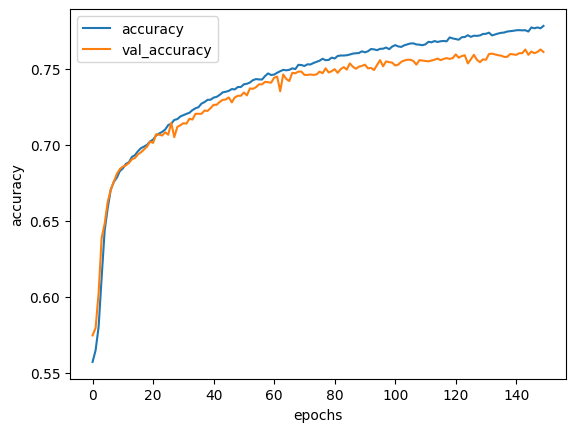

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

모델을 더 오래 훈련해도 결과는 비슷하다.


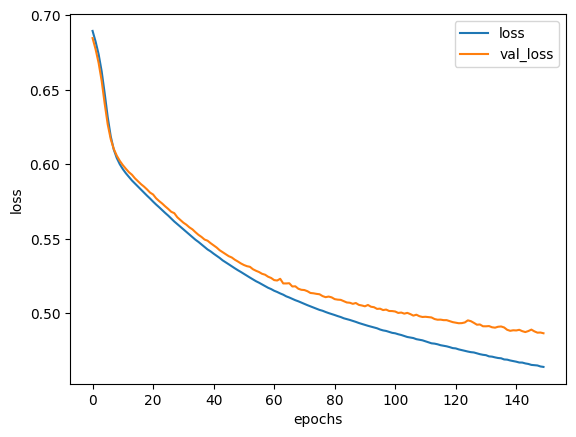

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

손실 곡선은 특정 에폭에서 발산되긴 하지만 그럼에도 잘 훈련된다.

이런 모델은 **조기종료**를 사용하면 좋다. 75~80 번의 에폭 동안만 훈련해 최적의 결과를 얻을 수 있다.

***

sarcasm 데이터셋에 빈정대는 헤드라인을 수집한 곳인 디 어니언의 헤드라인과 다른 문장을 섞어서 모델을 테스트해보겠다.

In [52]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

sequences = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(sequences, maxlen=max_length,
                       padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
print(pred)

1/1 [==============================] - 0s 41ms/step
[[0.31113392]
 [0.05455296]
 [0.69142884]
 [0.67999053]]


책과는 다르게 3, 4번째 문장이 빈정거리는 문장임